# Von Karman beam around the buckled state


first generate model using SSMTool


I use a high order Taylor expansion with the graph style. The normal form style always had invariant unstable subspaces: No other fixed points can exits.

In [9]:
import numpy as np
from scipy.io import loadmat

In [10]:
import matplotlib.pyplot as plt

In [11]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [12]:
import distinctipy

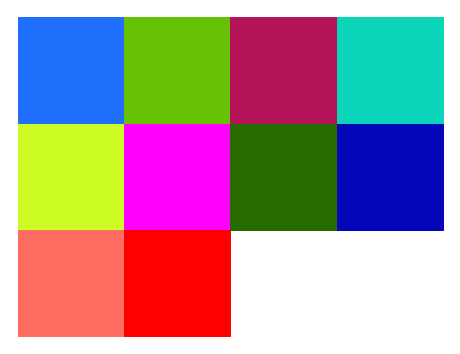

In [13]:
colors = distinctipy.get_colors(10,
                                n_attempts = 3000,
                                rng = 16,
                                pastel_factor = 0,
                                colorblind_type = 'Protanomaly')
#distinctipy.color_swatch(colors)
distinctipy.color_swatch(colors)


In [14]:
def get_coeff(expr):
    return expr.as_terms()[0][0][1][0][0] + 1j*expr.as_terms()[0][0][1][0][1]

In [15]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [16]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [17]:
def generate_parametrization(list_param, order_num=3, order_denom=3, use_robust = False):
    parametrization_pade = []
    for p in list_param:
        pad = taylor_to_pade.approximant.PadeApproximant(order_numerator=order_num,
                                                         order_denominator=order_denom,
                                                         base = [p1, p2])
        pad.initialize_from_taylor(p.coefficients, use_robust = use_robust)
        parametrization_pade.append(pad)
    return parametrization_pade

In [18]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [19]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [20]:
def return_parametrization_up_to_order_Taylor(parametrization_expressions, max_order = 30):
    parametrization = []
    for p in parametrization_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(p[0], [p1, p2], max_order)
        parametrization.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    return parametrization

In [21]:
def return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions, max_order = 30):
    red_dynamics = []
    for r in reduced_dynamics_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(r[0], [p1, p2], max_order)
        red_dynamics.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    for r in red_dynamics:
        r.polynomial = discard_small_coeffs(r.polynomial, tolerance = 1e-10)
    radial_variables, angle_variables, r_equations, phi_equations = taylor_to_pade.utils.convert_to_polar([p1, p2], [r.polynomial for r in red_dynamics])
    
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(phi_equations[0], radial_variables, max_order)
    frequency_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(r_equations[0], radial_variables, max_order)
    damping_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    damping_curve_taylor_ = sy.lambdify(radial_variables[0], -r_equations[0]/radial_variables[0], 'numpy')
    damping_curve_taylor = lambda x : np.real(damping_curve_taylor_(x))
    return red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables#, r_equations, phi_equations

In [22]:
def reduced_dynamics(frequency, damping, order_num = 3, order_denom = 3, use_robust = False):
    frequency_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade.initialize_from_taylor(damping.coefficients, use_robust = use_robust)
    frequency_Pade.initialize_from_taylor(frequency.coefficients, use_robust = use_robust)
    return frequency_Pade, damping_Pade

Load SSM coeffs

In [23]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_buckled_order18.mat')


In [24]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [25]:
%load_ext autoreload
%autoreload 2
%aimport taylor_to_pade


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import taylor_to_pade

In [27]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

In [28]:
def unpack_it(variables, coeff, exps):
    p1, p2 = variables
    val = 0
    for ex, cc in zip(exps,coeff):
        val += cc * p1**ex[0] * p2 ** ex[1]
    return val

In [29]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [30]:
outdof = 34

In [31]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [32]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [33]:
def get_resp_at_r(r, idx):
    phi_sample = np.linspace(0, 2*np.pi, 100)
    z1 = r * np.exp(1j*phi_sample)
    zz = np.vstack((z1, np.conjugate(z1))).reshape(2,-1)
    response_taylor = np.real(parametrization[idx].evaluate(zz.T))
    return np.max(np.abs(response_taylor))

In [34]:
sample_rs = np.linspace(1e-7, 1e-3, 1000)

In [35]:
orders = np.arange(3, 10, 1)


In [36]:
colormap = plt.cm.copper

### Extract the Taylor series

In [37]:
parametrization_18 = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                            max_order = 18)
red_dynamics_18 = return_parametrization_up_to_order_Taylor(reduced_dynamics_expressions,max_order = 18)
                                                                                                                     



Parametrization? 

In [38]:
rhotest = np.linspace(1e-4, 1e-3, 128)
RHO, THETA = np.meshgrid(rhotest,np.arange(0, 2*np.pi, 2*np.pi/128))
zdof1 = np.zeros(RHO.shape)
XX = RHO * np.sin(THETA)
YY = RHO * np.cos(THETA)

In [39]:


for k in range(128):
    pk = RHO[k,:]*np.exp(1j*THETA[k,:])
    pk_conj = RHO[k,:]*np.exp(1j*THETA[k,:])
    eval_pts = np.vstack((pk.ravel(), pk_conj.ravel())).T
    zk =  parametrization_18[0].evaluate(eval_pts).reshape(pk.shape)
    zdof1[k,:] = zk


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3980932874.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  zdof1[k,:] = zk


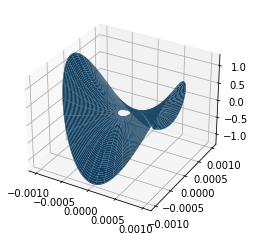

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zdof1)

## Visualize the reduced dynamics:

In [42]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [43]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [44]:
parametrization_pade = generate_parametrization(parametrization_18,
                                                order_num = 5,
                                                order_denom = 2,
                                                use_robust = True)


In [45]:
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
zz = parametrization_18[0].evaluate(pts).reshape(XX.shape)
zz_pade = parametrization_pade[0].evaluate(pts).reshape(XX.shape)


In [46]:
red_dynamics_18[0].polynomial

60.6464798684677*p_1**18 + 2944.48045215601*p_1**17*p_2 + 6.09209564803817e+18*p_1**17 + 39383.9743346763*p_1**16*p_2**2 + 1.05879293945982e+20*p_1**16*p_2 - 0.285524361499209*p_1**16 + 277117.414762804*p_1**15*p_2**3 + 8.61384239875897e+20*p_1**15*p_2**2 - 12.3890082937987*p_1**15*p_2 - 2.97327786625565e+16*p_1**15 + 1244864.52764396*p_1**14*p_2**4 + 4.35456447033411e+21*p_1**14*p_2**3 - 144.284555848919*p_1**14*p_2**2 - 4.53411027533375e+17*p_1**14*p_2 + 0.00135338940614495*p_1**14 + 3871398.82702697*p_1**13*p_2**5 + 1.53130408926268e+22*p_1**13*p_2**4 - 870.045488402082*p_1**13*p_2**3 - 3.20774504895907e+18*p_1**13*p_2**2 + 0.0519606332723014*p_1**13*p_2 + 149007615325352.0*p_1**13 + 8027129.68510057*p_1**12*p_2**6 + 3.97338521098323e+22*p_1**12*p_2**5 - 3269.05549269513*p_1**12*p_2**4 - 1.39592156802486e+19*p_1**12*p_2**3 + 0.514363091488748*p_1**12*p_2**2 + 1.95609603444127e+15*p_1**12*p_2 - 6.3722884273657e-6*p_1**12 + 20356512.2315405*p_1**11*p_2**7 + 7.87446933540198e+22*p_1**1

(-0.1, 0.1)

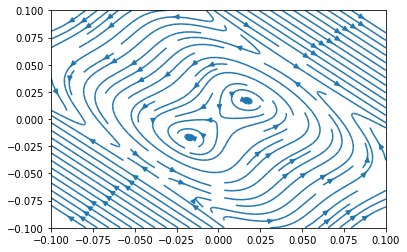

In [47]:
plt.streamplot(XX, YY, UU, VV)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


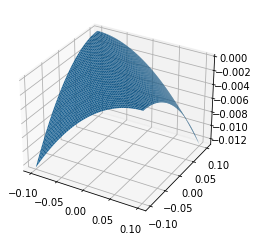

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zz_pade)

In [724]:
red_dyn_pade = generate_parametrization(red_dynamics_18, order_num = 3, order_denom = 3, use_robust = True)


In [725]:
xx = np.linspace(-5e-2, 2e-2, 100)

XX, YY = np.meshgrid(xx, xx)


In [726]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [727]:
UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

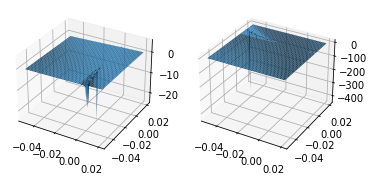

In [728]:
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, UU)
ax2.plot_surface(XX, YY, VV)

In [729]:
red_dynamics_18[0].polynomial.subs(p2, 0)

-228.503875448053*p_1**18 + 2.28025979222972e+18*p_1**17 + 1.08694462763405*p_1**16 - 1.19313534907684e+16*p_1**15 - 0.00522507665065024*p_1**14 + 64123299410197.8*p_1**13 + 2.53675427067556e-5*p_1**12 - 356722540252.537*p_1**11 - 1.24672247804461e-7*p_1**10 + 2078899821.11358*p_1**9 + 6.23307188015699e-10*p_1**8 - 12929478.3927937*p_1**7 - 2.61638026434577e-12*p_1**6 + 92903.4804061775*p_1**5 + 5.37775365703221e-14*p_1**4 - 2789.48440650302*p_1**3 - 3.59360706309951e-16*p_1**2 + 23.4842291125072*p_1

(-0.05, 0.02)

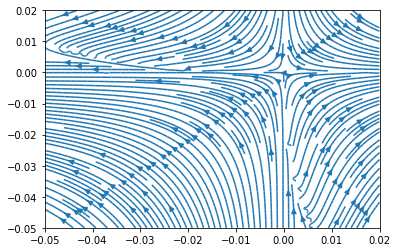

In [730]:
plt.streamplot(XX, YY, UU, VV, density = 2)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


## With increased loading: 

This is with 1.45 critical load

In [56]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_buckled_mid_load_order18.mat')


In [731]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [732]:
%load_ext autoreload
%autoreload 2
%aimport taylor_to_pade


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [733]:
import taylor_to_pade

In [734]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

KeyError: 'W0'

In [735]:
def unpack_it(variables, coeff, exps):
    p1, p2 = variables
    val = 0
    for ex, cc in zip(exps,coeff):
        val += cc * p1**ex[0] * p2 ** ex[1]
    return val

In [736]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [737]:
outdof = 34

In [738]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [739]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [740]:
def get_resp_at_r(r, idx):
    phi_sample = np.linspace(0, 2*np.pi, 100)
    z1 = r * np.exp(1j*phi_sample)
    zz = np.vstack((z1, np.conjugate(z1))).reshape(2,-1)
    response_taylor = np.real(parametrization[idx].evaluate(zz.T))
    return np.max(np.abs(response_taylor))

In [741]:
sample_rs = np.linspace(1e-7, 1e-3, 1000)

In [742]:
orders = np.arange(3, 10, 1)


In [743]:
colormap = plt.cm.copper

### Extract the Taylor series

In [71]:
parametrization_18 = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                            max_order = 18)
red_dynamics_18 = return_parametrization_up_to_order_Taylor(reduced_dynamics_expressions,max_order = 18)
                                                                                                                     



Parametrization? 

In [72]:
rhotest = np.linspace(1e-4, 1e-3, 128)
RHO, THETA = np.meshgrid(rhotest,np.arange(0, 2*np.pi, 2*np.pi/128))
zdof1 = np.zeros(RHO.shape)
XX = RHO * np.sin(THETA)
YY = RHO * np.cos(THETA)

In [73]:


for k in range(128):
    pk = RHO[k,:]*np.exp(1j*THETA[k,:])
    pk_conj = RHO[k,:]*np.exp(1j*THETA[k,:])
    eval_pts = np.vstack((pk.ravel(), pk_conj.ravel())).T
    zk =  parametrization_18[0].evaluate(eval_pts).reshape(pk.shape)
    zdof1[k,:] = zk


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3980932874.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  zdof1[k,:] = zk


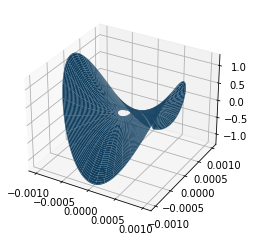

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zdof1)

## Visualize the reduced dynamics:

In [744]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [745]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [746]:
parametrization_pade = generate_parametrization(parametrization_18,
                                                order_num = 3,
                                                order_denom = 3,
                                                use_robust = True)


In [747]:
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
zz = parametrization_18[0].evaluate(pts).reshape(XX.shape)
zz_pade = parametrization_pade[0].evaluate(pts).reshape(XX.shape)


In [748]:
red_dynamics_18[0].polynomial

-228.503875448053*p_1**18 - 5522.54502028413*p_1**17*p_2 + 2.28025979222972e+18*p_1**17 - 60188.1213845768*p_1**16*p_2**2 + 4.32239774876838e+19*p_1**16*p_2 + 1.08694462763405*p_1**16 - 395899.701776842*p_1**15*p_2**3 + 3.82057753440777e+20*p_1**15*p_2**2 + 23.5505436805842*p_1**15*p_2 - 1.19313534907684e+16*p_1**15 - 1764587.84970074*p_1**14*p_2**4 + 2.08547052927842e+21*p_1**14*p_2**3 + 226.212862516076*p_1**14*p_2**2 - 1.978976675882e+17*p_1**14*p_2 - 0.00522507665065024*p_1**14 - 5639427.41864216*p_1**13*p_2**5 + 7.84602438488205e+21*p_1**13*p_2**4 + 1289.28194830846*p_1**13*p_2**3 - 1.51310213557586e+18*p_1**13*p_2**2 - 0.100030125672705*p_1**13*p_2 + 64123299410197.8*p_1**13 - 13020653.9794826*p_1**12*p_2**6 + 2.15018559494613e+22*p_1**12*p_2**5 + 4877.39454592454*p_1**12*p_2**4 - 7.04937429418267e+18*p_1**12*p_2**3 - 0.829211451406705*p_1**12*p_2**2 + 910205381839672.0*p_1**12*p_2 + 2.53675427067556e-5*p_1**12 - 26710019.3682773*p_1**11*p_2**7 + 4.42432320360607e+22*p_1**11*p_2*

(-0.1, 0.1)

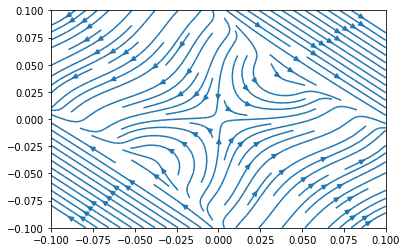

In [749]:
plt.streamplot(XX, YY, UU, VV)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


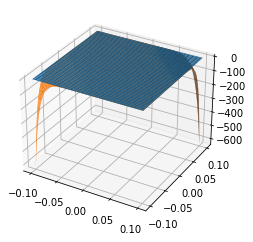

In [750]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zz_pade)
ax.plot_surface(XX, YY, zz)

In [751]:
red_dyn_pade = generate_parametrization(red_dynamics_18, order_num = 6, order_denom = 6, use_robust = True)


In [752]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [753]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [754]:
UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

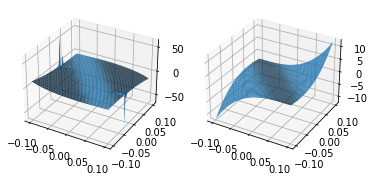

In [755]:
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, UU)
ax2.plot_surface(XX, YY, VV)

In [756]:
red_dynamics_18[0].polynomial.subs(p2, 0)

-228.503875448053*p_1**18 + 2.28025979222972e+18*p_1**17 + 1.08694462763405*p_1**16 - 1.19313534907684e+16*p_1**15 - 0.00522507665065024*p_1**14 + 64123299410197.8*p_1**13 + 2.53675427067556e-5*p_1**12 - 356722540252.537*p_1**11 - 1.24672247804461e-7*p_1**10 + 2078899821.11358*p_1**9 + 6.23307188015699e-10*p_1**8 - 12929478.3927937*p_1**7 - 2.61638026434577e-12*p_1**6 + 92903.4804061775*p_1**5 + 5.37775365703221e-14*p_1**4 - 2789.48440650302*p_1**3 - 3.59360706309951e-16*p_1**2 + 23.4842291125072*p_1

(-0.1, 0.1)

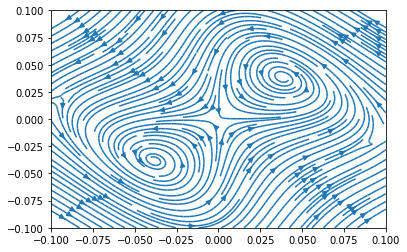

In [757]:
plt.streamplot(XX, YY, UU, VV, density = 2)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


## load the data

In [2]:
from scipy.io import loadmat

In [3]:
dat = loadmat('dataVK_buckled_unforced_mid.mat')

In [4]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DataInfo', 'sol_minus', 'sol_plus', 'unstable_fp'])

Project onto SSM: 

In [759]:
W_1 = W0[0]['coeffs']

To find the correct xi_point: 

$$
\xi w_1 = \omega $$

In [760]:
plus_ = dat['sol_plus']- dat['unstable_fp'].T
minus_ = dat['sol_minus'] - dat['unstable_fp'].T


In [1173]:
outdof

34

In [762]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DataInfo', 'sol_minus', 'sol_plus', 'unstable_fp'])

In [763]:
reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3020135435.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3020135435.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


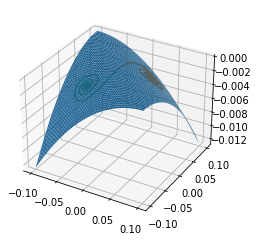

In [764]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zz_pade)
ax.plot(reduced_plus[0,:], reduced_plus[1,:], plus_[:,outdof])
ax.plot(reduced_minus[0,:], reduced_minus[1,:], minus_[:,outdof])

In [1085]:
zz_pade.max()

6.951638167150865e-07

In [1086]:
zz_pade.min()

-0.012566941610132812

In [1099]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

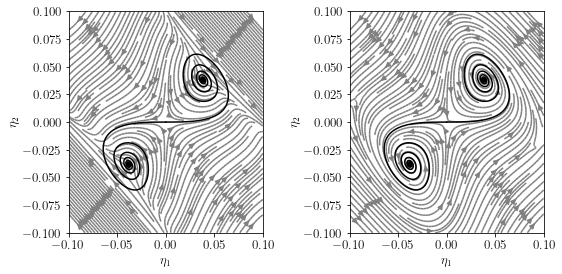

In [1162]:
ff = plt.figure(figsize = (8, 4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
streamplotobject_taylor = ax.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax.plot(reduced_plus[1,:], reduced_plus[0,:], c= 'black')
ax.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(xx.min(), xx.max())

UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

streamplotobject_pade = ax2.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax2.plot(reduced_plus[1,:], reduced_plus[0,:] , c= 'black')
ax2.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(xx.min(), xx.max())
ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/mid_load_phase.pdf', bbox_inches='tight')

In [1163]:
# get the segments generated by the streamplot
segments_pade = []
for l in streamplotobject_pade.lines.get_paths():
    v = np.array(l.vertices)
    segments_pade.append(v)
    
segments_taylor = []
for l in streamplotobject_taylor.lines.get_paths():
    v = np.array(l.vertices)
    segments_taylor.append(v)   


In [1191]:
segments_zcoord_pade = [np.real(parametrization_pade_54_FULL[outdof].evaluate(s)) for s in segments_pade]
segments_zcoord_taylor = [np.real(parametrization_18[0].evaluate(s)) for s in segments_taylor]


In [1177]:
zcoord_minus_taylor = parametrization_18[0].evaluate(sol_minus_taylor.y.T)
zcoord_plus_taylor = parametrization_18[0].evaluate(sol_plus_taylor.y.T)
zcoord_minus_pade = parametrization_pade_54_FULL[outdof].evaluate(sol_minus_pade.y.T)
zcoord_plus_pade = parametrization_pade_54_FULL[outdof].evaluate(sol_plus_pade.y.T)



In [1184]:
dict_to_save = {}
dict_to_save['segments_zcoord_pade'] = segments_zcoord_pade
dict_to_save['segments_zcoord_taylor'] = segments_zcoord_taylor
dict_to_save['segments_taylor'] = segments_taylor
dict_to_save['segments_pade'] = segments_pade
dict_to_save['zcoord_minus_taylor'] = zcoord_minus_taylor
dict_to_save['zcoord_plus_taylor'] = zcoord_plus_taylor
dict_to_save['zcoord_minus_pade'] = zcoord_minus_pade
dict_to_save['zcoord_plus_pade'] = zcoord_plus_pade
dict_to_save['sol_minus_pade'] = sol_minus_pade.y
dict_to_save['sol_plus_pade'] = sol_plus_pade.y
dict_to_save['sol_minus_taylor'] = sol_minus_taylor.y
dict_to_save['sol_plus_taylor'] = sol_plus_taylor.y



In [1185]:
from scipy.io import savemat


In [1186]:
savemat('bucked_mid_nonforced_reconst_data.mat', dict_to_save)

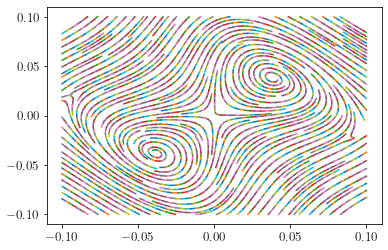

In [1172]:
for s in segments_pade:
    plt.plot(s[:,0], s[:,1])

Verify now the conjugacy: 

In [1247]:
ic_plus_reduced = reduced_plus[:,0][::-1]
ic_minus_reduced = reduced_minus[:,0][::-1]


In [1248]:
def odeint_pade(t, x):
    return np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()

def odeint_tay(t, x):
    return np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()

In [1267]:
sy.Matrix([r.polynomial for r in red_dynamics_18]).jacobian([p1,p2]).subs([(p1, 0), (p2,0)])

Matrix([
[23.4842291125072,                 0],
[               0, -23.5294698288897]])

In [1300]:
coeffs_poly_1 = dict(red_dynamics_18[0].polynomial.as_coefficients_dict())
coeffs_poly_2 = dict(red_dynamics_18[1].polynomial.as_coefficients_dict())

In [1309]:
coeffs_poly_2[p1**2*p2]

7297.75747743623

In [1249]:
from scipy.integrate import solve_ivp

In [1893]:
teval = np.linspace(0, 2, 2000)
sol_plus_pade = solve_ivp(odeint_pade, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_pade = solve_ivp(odeint_pade, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


sol_plus_taylor = solve_ivp(odeint_tay, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_taylor = solve_ivp(odeint_tay, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


<lambdifygenerated-14>:2: RuntimeWarning: overflow encountered in power
  return -228.503875448053*p_1**18 - 5522.54502028413*p_1**17*p_2 + 2.28025979222972e+18*p_1**17 - 60188.1213845768*p_1**16*p_2**2 + 4.32239774876838e+19*p_1**16*p_2 + 1.08694462763405*p_1**16 - 395899.701776842*p_1**15*p_2**3 + 3.82057753440777e+20*p_1**15*p_2**2 + 23.5505436805842*p_1**15*p_2 - 1.19313534907684e+16*p_1**15 - 1764587.84970074*p_1**14*p_2**4 + 2.08547052927842e+21*p_1**14*p_2**3 + 226.212862516076*p_1**14*p_2**2 - 1.978976675882e+17*p_1**14*p_2 - 0.00522507665065024*p_1**14 - 5639427.41864216*p_1**13*p_2**5 + 7.84602438488205e+21*p_1**13*p_2**4 + 1289.28194830846*p_1**13*p_2**3 - 1.51310213557586e+18*p_1**13*p_2**2 - 0.100030125672705*p_1**13*p_2 + 64123299410197.8*p_1**13 - 13020653.9794826*p_1**12*p_2**6 + 2.15018559494613e+22*p_1**12*p_2**5 + 4877.39454592454*p_1**12*p_2**4 - 7.04937429418267e+18*p_1**12*p_2**3 - 0.829211451406705*p_1**12*p_2**2 + 910205381839672.0*p_1**12*p_2 + 2.53675427067556

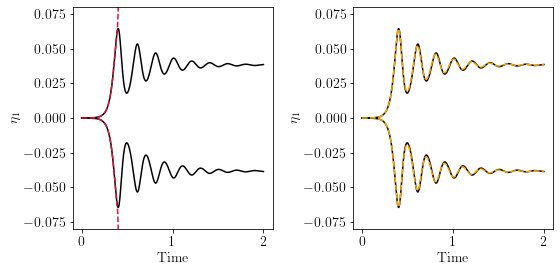

In [1894]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax2.plot(sol_minus_pade.t, reduced_minus[1,:], '-', c='black')
ax2.plot(sol_minus_pade.t, sol_minus_pade.y[0,:], '--', c='orange')


ax2.plot(teval, reduced_plus[1,:], '-', c='black')
ax2.plot(sol_plus_pade.t, sol_plus_pade.y[0,:], '--', c='orange')



ax.plot(teval, reduced_minus[1,:], '-', c='black')
ax.plot(sol_minus_taylor.t, sol_minus_taylor.y[0,:], '--', c='crimson')


ax.plot(teval, reduced_plus[1,:], '-', c='black')
ax.plot(sol_plus_taylor.t, sol_plus_taylor.y[0,:], '--', c='crimson')
ax.set_xlabel('Time')
ax2.set_xlabel('Time')
ax.set_ylabel('$\eta_1$')
ax2.set_ylabel('$\eta_1$')
ax.set_ylim(-0.08, 0.08)
ax2.set_ylim(-0.08, 0.08)

plt.tight_layout()
plt.savefig('figs/mid_load_reconstruction.pdf', bbox_inches='tight')

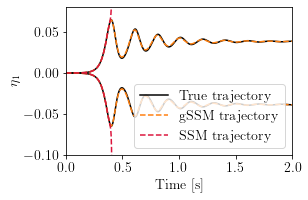

In [1899]:
ff = plt.figure(figsize = (4.5,3))
ax = ff.add_subplot(111)

ax.plot(teval, reduced_minus[1,:], '-', c='black', label = 'True trajectory')

ax.plot(sol_minus_pade.t, sol_minus_pade.y[0,:], '--', c='C1', label = 'gSSM trajectory')
ax.plot(sol_minus_taylor.t, sol_minus_taylor.y[0,:], '--', c='crimson', label = 'SSM trajectory')


ax.plot(teval, reduced_plus[1,:], '-', c='black')
ax.plot(sol_plus_pade.t, sol_plus_pade.y[0,:], '--', c='C1')
ax.plot(sol_plus_taylor.t, sol_plus_taylor.y[0,:], '--', c='crimson')

ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
ax.set_ylim(-0.1, 0.08)
ax.set_xlim(0, 2)
ax.legend(loc='lower right', fontsize = 14.25)
plt.tight_layout()
plt.savefig('figs/mid_load_reconstruction_joint.pdf', bbox_inches='tight')

## Added_dec 3: save the reconstructed trajectories as well


In [1070]:
pade_traj = [np.real(pp.evaluate(sol_1_pade.y.T))
      for pp in parametrization_pade_54_FULL]

In [1098]:
dat['sol_ep1'].min()

-1.1708307802986562

In [1076]:
np.array(pade_traj)

0.07556963885851326

In [1079]:
dict_to_save = {}
dict_to_save['pade_chaotic_traj'] = np.array(pade_traj)

In [706]:
from scipy.io import savemat


In [1080]:
savemat('bucked_chaotic_pade_calibrated_amplitude.mat', dict_to_save)

### THis seems to work

Now add the forcing. This should be simply a projection to the tangent space

In [771]:
M = loadmat('M.mat')['M_']

In [772]:
W_1 = W0[0]['coeffs']

In [773]:
f_periodic  = np.zeros((36,1))
f_periodic[17,0] = 1 # forcing on midpoint

Amp = 21.1154#75.7#3.4#2.93#3.4
Frq = 30 # forcing amplitude and frequency in full state space
Minv = np.linalg.inv(M)

F_f = Amp*(Minv@f_periodic)

F_f_first_order = np.vstack((np.zeros((36,1)), F_f))# + dat['unstable_fp']

#f_reduced = 

In [774]:
F_reduced = np.linalg.lstsq(W_1, F_f_first_order)[0].ravel()

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/1200291864.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F_reduced = np.linalg.lstsq(W_1, F_f_first_order)[0].ravel()


In [775]:
F_reduced

array([ 1.72935943, -1.72935943])

In [776]:
def odeint_pade_forced(t, x):
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + -F_reduced * np.cos(Frq * t)

def odeint_tay_forced(t, x):
    autonomous = np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + -F_reduced * np.cos(Frq * t)

In [777]:
np.random.seed(3)
ic1 = sol_plus_pade.y[:,-1]
ic2 = sol_plus_pade.y[:,-1] + (np.random.rand(2)-0.5) * 1e-5 


In [778]:
from scipy.optimize import root
def find_fp(x0):
    ll = lambda x: odeint_pade_aut(0, x.reshape(1,-1)).ravel()
    return root(ll, x0).x

def find_eigs(x0):
    step = 1e-6
    DX = np.array([step, 0])
    DY = np.array([0., step])
    ll = lambda x: odeint_pade_aut(0, x.reshape(1,-1)).ravel()

    dxdx = (ll(x0 + DX) - ll(x0 - DX)) / (2 * step)
    dydx = (ll(x0 + DY) - ll(x0 - DY)) / (2 * step)
    mtx = np.vstack((dxdx.ravel(), dydx.ravel())).T
    return np.linalg.eig(mtx)[0]

In [779]:
fp1 = find_fp(sol_plus_pade.y[:,-1])

In [780]:
find_eigs(fp1)

array([-3.0429969+31.80188178j, -3.0429969-31.80188178j])

In [781]:
ic1

array([0.03850899, 0.03808604])

In [782]:
ic2

array([0.0385095 , 0.03808813])

In [783]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = timescale#endTime/(nSamp-1);
timespan = np.arange(0, endTime, dt)

In [784]:
sol_chaotic_pade_1 = solve_ivp(odeint_pade_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
sol_chaotic_pade_2 = solve_ivp(odeint_pade_forced, [0,endTime], ic2, t_eval = timespan, method = 'DOP853', rtol = 1e-12)

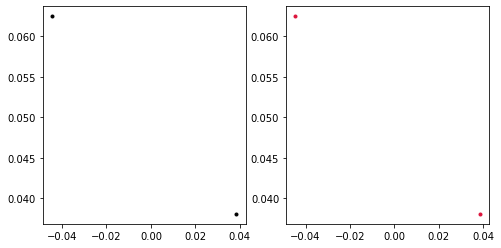

In [785]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(sol_chaotic_pade_1.y[0,:], sol_chaotic_pade_1.y[1,:], '.', c='black')
#ax.plot(timespan, sol_chaotic_pade_1.y[1,:], '.', c='black')
#ax.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
#ax.set_xlim(0, 10)
#ax2.plot(sol_chaotic_pade_1.y[0,:], sol_chaotic_pade_1.y[1,:], '-', c='black')
#ax2.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
ax2.plot(sol_chaotic_pade_2.y[0,0:], sol_chaotic_pade_2.y[1,0:], '.', c='crimson')

Let's scan the range of amplitudes to find chaos:

In [360]:
from tqdm import tqdm

In [361]:
amplitudes = np.linspace(0., 0.5, 10)

In [362]:
amplitudes[-3]

0.38888888888888884

In [363]:
frq_

23.957894736842107

In [812]:
resp = []
for a in tqdm(amplitudes):
    def odeint_pade_forced(t, x):
        autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                       red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
        return autonomous + np.array([a, -a]) * np.cos(Frq * t)
    teval = np.linspace(0, 2, 2000)
    sol_chaotic_pade_1 = solve_ivp(odeint_pade_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
    #sol_chaotic_pade_2 = solve_ivp(odeint_pade_forced, [0,endTime], ic2, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
    resp.append(sol_chaotic_pade_1.y)

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.90s/it]


In [813]:
resp = np.array(resp)

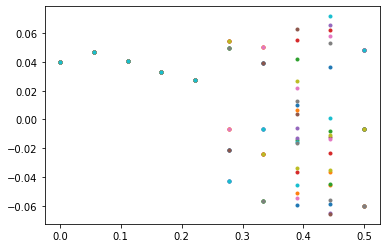

In [814]:
plt.plot(amplitudes, resp[:, 0, -20:], '.')

Looks like the frequency needed to be changed

### Scan through the frequency as well: 

- the low amplitude forcing worked, so let's try to keep that

In [1104]:

amp_low = 2.2*0.0774

In [569]:
frequencies = np.linspace(23.2, 24, 20)
frequencies = np.linspace(20, 30, 40)
frequencies = np.linspace(25.25, 25.5, 40)

In [570]:
resp = []
for frq in tqdm(frequencies):
    timescale = 2*np.pi/frq
    numberPeriods = 100
    numberPointsPerPeriod = 100
    endTime = numberPeriods*timescale;
    nSamp = numberPeriods*numberPointsPerPeriod+1
    dt = timescale#endTime/(nSamp-1);
    timespan = np.arange(0, endTime, dt)


    
    
    def odeint_pade_forced(t, x):
        autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                       red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
        return autonomous + np.array([amp_low, -amp_low]) * np.cos(frq * t)

    sol_chaotic_pade_1 = solve_ivp(odeint_pade_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-6)
    resp.append(sol_chaotic_pade_1.y)


100%|███████████████████████████████████████████| 40/40 [02:42<00:00,  4.06s/it]


In [573]:
frequencies

array([25.25      , 25.25641026, 25.26282051, 25.26923077, 25.27564103,
       25.28205128, 25.28846154, 25.29487179, 25.30128205, 25.30769231,
       25.31410256, 25.32051282, 25.32692308, 25.33333333, 25.33974359,
       25.34615385, 25.3525641 , 25.35897436, 25.36538462, 25.37179487,
       25.37820513, 25.38461538, 25.39102564, 25.3974359 , 25.40384615,
       25.41025641, 25.41666667, 25.42307692, 25.42948718, 25.43589744,
       25.44230769, 25.44871795, 25.45512821, 25.46153846, 25.46794872,
       25.47435897, 25.48076923, 25.48717949, 25.49358974, 25.5       ])

(25.3, 25.35)

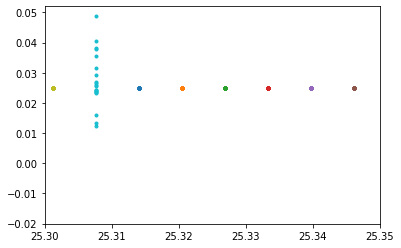

In [587]:
for f,r in zip(frequencies,resp):
    plt.plot(f*np.ones(20), r[ 0, -20:], '.')
plt.xlim(25.3, 25.35)

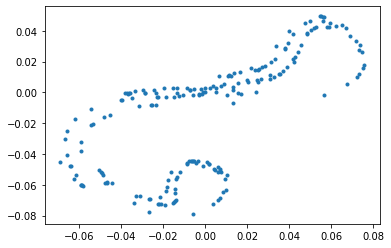

In [815]:
plt.plot(resp[-3, 0,:], resp[-3, 1,:],'.')

In [372]:
frq_ = frequencies[-2]

In [373]:
frq_

23.957894736842107

In [1105]:
frq_ = 25.30769231

In [793]:
def odeint_pade_forced(t, x):
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([1.1*amp_low, -1.1*amp_low]) * np.cos(frq_ * t)
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.arange(0, endTime, dt)

In [794]:
1.1*amp_low

0.18730800000000003

In [795]:
sol_chaotic_pade_1 = solve_ivp(odeint_pade_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
sol_chaotic_pade_2 = solve_ivp(odeint_pade_forced, [0,endTime], ic2, t_eval = timespan, method = 'DOP853', rtol = 1e-12)

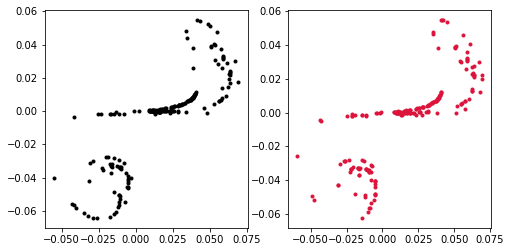

In [790]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(sol_chaotic_pade_1.y[0,:], sol_chaotic_pade_1.y[1,:], '.', c='black')
#ax.plot(timespan, sol_chaotic_pade_1.y[1,:], '.', c='black')
#ax.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
#ax.set_xlim(0, 10)
#ax2.plot(sol_chaotic_pade_1.y[0,:], sol_chaotic_pade_1.y[1,:], '-', c='black')
#ax2.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
ax2.plot(sol_chaotic_pade_2.y[0,0:], sol_chaotic_pade_2.y[1,0:], '.', c='crimson')

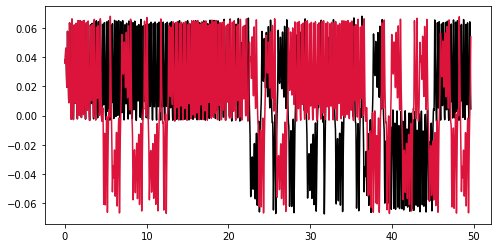

In [797]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(111)
ax.plot(sol_chaotic_pade_1.t, sol_chaotic_pade_1.y[1,:], '-', c='black')
#ax.plot(timespan, sol_chaotic_pade_1.y[1,:], '.', c='black')
#ax.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
#ax.set_xlim(0, 10)
#ax2.plot(sol_chaotic_pade_1.y[0,:], sol_chaotic_pade_1.y[1,:], '-', c='black')
#ax2.plot(sol_chaotic_pade_2.y[0,:], sol_chaotic_pade_2.y[1,:], '--', c='crimson')
ax.plot(sol_chaotic_pade_2.t, sol_chaotic_pade_2.y[1,0:], '-', c='crimson')
#ax.set_xlim(0, 10)

Looks like lorenz

In [798]:
amplitudes[-1]

0.5

### Interestingly an amplitde of 1 produces a chaotic attractor here

Need to reverse engineer the forcing in the physical space: 

In [1900]:
dat = loadmat('dataVK_buckled_forced_chaotic_mid_from_average.mat')

Project onto SSM: 

In [1901]:
W_1 = W0[0]['coeffs']

In [1902]:
traj1 = dat['sol_ep1']- dat['unstable_fp'].T
traj2 = dat['sol_ep2'] - dat['unstable_fp'].T


In [1903]:
reduced_traj1 = np.linalg.lstsq(W_1, traj1.T)[0]
reduced_traj2 = np.linalg.lstsq(W_1, traj2.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/1885590696.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_traj1 = np.linalg.lstsq(W_1, traj1.T)[0]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/1885590696.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_traj2 = np.linalg.lstsq(W_1, traj2.T)[0]


In [803]:
reduced_traj1 = dat['reduced']

reduced_traj1_proj = np.linalg.lstsq(W_1, traj1.T)[0]
#reduced_traj2 = np.linalg.lstsq(W_1, traj2.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/2147080073.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_traj1_proj = np.linalg.lstsq(W_1, traj1.T)[0]


In [804]:
reduced_traj1.shape

(2, 1001)

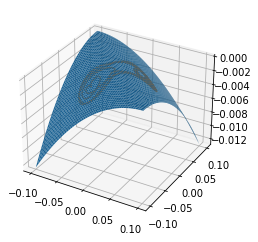

In [805]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot_surface(TT1, TT2, pad_18_ro)
#ax.plot_surface(TT1, TT2, pad_9)
ax.plot_surface(XX, YY, zz_pade)
ax.plot(reduced_traj1[1,:], reduced_traj1[0,:], traj1[:,outdof])
#ax.plot(reduced_traj2[0,:], reduced_traj2[1,:], traj2[:,outdof])

In [1093]:
dict_to_save = {}
dict_to_save['XX'] = XX
dict_to_save['YY'] = YY
dict_to_save['zz_pade'] = zz_pade
dict_to_save['zz_taylor'] = zz
dict_to_save['reduced_traj2'] = reduced_traj2
dict_to_save['reduced_traj1'] = reduced_traj1

dict_to_save['sol_1_pade'] = sol_1_pade.y
dict_to_save['sol_2_pade'] = sol_2_pade.y



In [1094]:
savemat('bucked_mid_surface_plots.mat', dict_to_save)

In [1155]:
ampl_from_ssmtool = 1.1*amp_low#amp_low#0.5385#4.97093429#-0.6516#0.34104522#0.3511#410#45#0.3410
def odeint_pade_forced(t, x):
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([ampl_from_ssmtool, -ampl_from_ssmtool]) * np.cos(frq_ * t) #- np.array([0.00247784130303642, -0.00247784130303642])

In [1156]:
ampl_from_ssmtool

0.18730800000000003

In [1157]:
ic_chaot1_reduced = reduced_traj1[:,0][::-1]
ic_chaot2_reduced = reduced_traj2[:,0][::-1]


In [1158]:
from scipy.integrate import solve_ivp

In [1159]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1160]:
sol_1_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



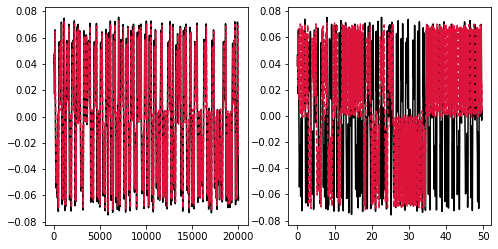

In [957]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(reduced_traj1[1,:], '-', c='black')
ax.plot(reduced_traj1_proj[0,:], '--', c='crimson')


ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax2.plot(sol_2_pade.t, sol_2_pade.y[0,:], '--', c='crimson')
#ax.set_xlim(0, 1.5)
#ax2.set_xlim(0, 1.5)

In [ ]:
timescale

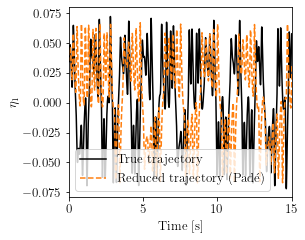

In [1112]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)
#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '--', c='C1', label = 'Reduced trajectory (Padé)')
#ax.plot(sol_1_taylor.t, sol_1_taylor.y[1,:], '-', c='black')
ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 15)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
plt.savefig('figs/chaot_forced_mid_load.pdf', bbox_inches='tight')

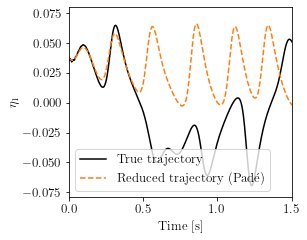

In [1113]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)
#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '--', c='C1', label = 'Reduced trajectory (Padé)')
#ax.plot(sol_1_taylor.t, sol_1_taylor.y[1,:], '-', c='black')
ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 1.5)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
plt.savefig('figs/chaot_forced_mid_load_zoom.pdf', bbox_inches='tight')

In [1114]:
frequencies = np.fft.fftfreq(len(reduced_traj1[1,:]), d=dt)
ff_true = np.fft.fft(reduced_traj1[1,:])
ff_reduced = np.fft.fft(sol_1_pade.y[0,:])
positive_frequencies = frequencies[frequencies >= 0]
positive_power_spectrum_true = ff_true[frequencies >= 0]
positive_power_spectrum_reduced = ff_reduced[frequencies >= 0]

(0.0, 30.0)

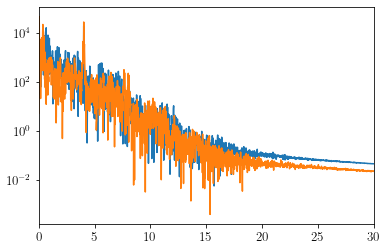

In [1115]:
plt.semilogy(positive_frequencies, np.abs(positive_power_spectrum_true)**2, '-')
plt.semilogy(positive_frequencies, np.abs(positive_power_spectrum_reduced)**2, '-')
plt.xlim(0, 30)

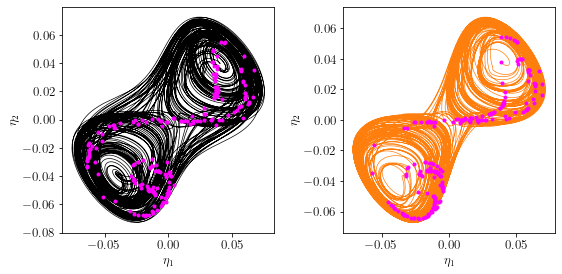

In [1161]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(reduced_traj2[1,:], reduced_traj2[0,:],'-',linewidth =0.7,c='black')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c=colors[5])

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax2.plot(sol_1_pade.y[0,:], sol_1_pade.y[1,:], '-',linewidth =0.7, c='C1')
ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c=colors[5])

ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/chaotic_forced_with_poincare_mid_load.pdf',bbox_inches='tight')

In [1118]:
timescale = 2*np.pi/frq_
numberPeriods = 600
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1119]:
teval = np.linspace(0, 20, 2000)
sol_1_pade_long = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
#sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



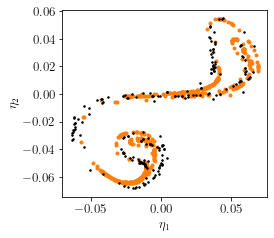

In [1120]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)

#ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black')

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 6, label = 'Reduced trajectory (Padé)')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
#ax.legend(loc = 'lower right')
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/chaotic_forced_only_poincare_mid_load.pdf',bbox_inches='tight')

### Let's try to match the derivatives

In [185]:
from findiff import FinDiff

In [186]:
DT = FinDiff(0,dt)

In [187]:
d_eta1 = DT(reduced_traj2[1,:],dt)
d_eta2 = DT(reduced_traj2[0,:],dt)


In [188]:
eta1 = reduced_traj2[1,:]
eta2 = reduced_traj2[0,:]
eta = np.vstack((eta1, eta2))

In [189]:
eta.shape

(2, 10001)

In [190]:
def odeint_pade_aut(t, x):
    autonomous = np.vstack((red_dyn_pade[0].evaluate(x),
                   red_dyn_pade[1].evaluate(x)))
    return autonomous #+ np.array([ampl_from_ssmtool, -ampl_from_ssmtool]) * np.cos(Frq * t)

In [191]:
autonomous_derivative_pred = odeint_pade_aut(0, eta.T)

In [192]:
np.linalg.lstsq(W_1, dat['unstable_fp'])

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3047400865.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(W_1, dat['unstable_fp'])


(array([[-9.01962721e-30],
        [ 5.64052396e-46]]),
 array([1.60495876e-08]),
 2,
 array([80.94828777,  3.4436011 ]))

In [1149]:
ampl_from_ssmtool

0.18730800000000003

(0.0, 2.0)

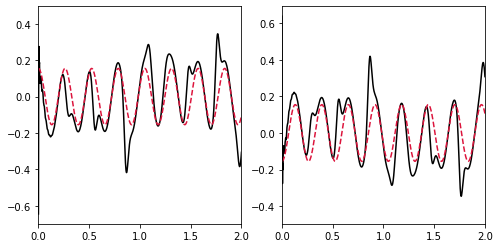

In [195]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(timespan, d_eta1 - autonomous_derivative_pred[0,:], '-', c='black')
ax.plot(timespan, ampl_from_ssmtool * np.cos(timespan * frq_), '--', c='crimson')


ax2.plot(timespan, d_eta2 - autonomous_derivative_pred[1,:], '-', c='black')
ax2.plot(timespan, -ampl_from_ssmtool * np.cos(timespan * frq_), '--', c='crimson')
ax.set_xlim(0, 2)#3.5)
ax2.set_xlim(0, 2)#3.5)


In [201]:
residual1 = d_eta1 - autonomous_derivative_pred[0,:]
residual2 = d_eta2 - autonomous_derivative_pred[1,:]
residual = np.vstack((residual1, residual2))
forcing = np.vstack((np.cos(timespan * Frq), np.sin(timespan * Frq)))

In [202]:
res = np.linalg.lstsq(forcing.T, residual.T)[0]

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/956551925.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(forcing.T, residual.T)[0]


In [203]:
res

array([[ 0.00393296, -0.00388758],
       [ 0.00462048, -0.00464236]])

## Extract the full IC:

In [697]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [698]:
%%time 
parametrization_18_FULL = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                            max_order = 18)

CPU times: user 1min 21s, sys: 92.3 ms, total: 1min 21s
Wall time: 1min 21s


In [699]:
%%time 
parametrization_pade_54_FULL = generate_parametrization(parametrization_18_FULL, order_num = 3, order_denom=3, use_robust = True)


CPU times: user 17.5 s, sys: 27.1 ms, total: 17.6 s
Wall time: 17.6 s


In [700]:
len(parametrization_pade_54_FULL)

72

In [701]:
IC = [np.real(pp.evaluate(ic1.reshape(1,-1)))
      for pp in parametrization_pade_54_FULL]

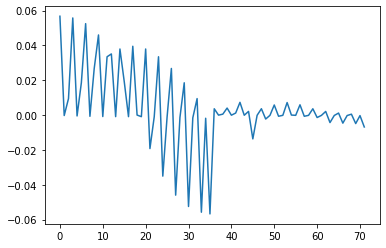

In [703]:
pl

In [704]:
dict_to_save = {}
dict_to_save['ic_'] = np.array(IC)

In [706]:
from scipy.io import savemat


In [707]:
savemat('buckled_chaotic_IC.mat', dict_to_save)

### December 2: 

Try to calibrate forcing:

In [962]:
to_calib = reduced_traj1[:, -5000:]

In [963]:
from findiff import FinDiff

In [964]:
DT = FinDiff(0,dt)

In [965]:
d_eta1 = DT(to_calib[1,:],dt)
d_eta2 = DT(to_calib[0,:],dt)


In [966]:
eta1 = to_calib[1,:]
eta2 = to_calib[0,:]
eta = np.vstack((eta1, eta2))

In [967]:
eta.shape

(2, 5000)

In [968]:
time_calib = timespan[-5000:]

In [969]:
time_calib.shape

(5000,)

In [970]:
def odeint_pade_aut(t, x):
    autonomous = np.vstack((red_dyn_pade[0].evaluate(x),
                   red_dyn_pade[1].evaluate(x)))
    return autonomous #+ np.array([ampl_from_ssmtool, -ampl_from_ssmtool]) * np.cos(Frq * t)

In [971]:
autonomous_derivative_pred = odeint_pade_aut(0, eta.T)

In [972]:
np.linalg.lstsq(W_1, dat['unstable_fp'])

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3047400865.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(W_1, dat['unstable_fp'])


(array([[-9.01962721e-30],
        [ 5.64052396e-46]]),
 array([1.60495876e-08]),
 2,
 array([80.94828777,  3.4436011 ]))

(37.5, 40.0)

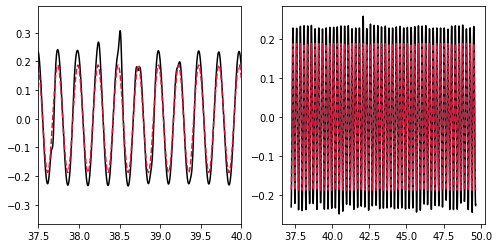

In [975]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(time_calib, d_eta1 - autonomous_derivative_pred[0,:], '-', c='black')
ax.plot(time_calib, ampl_from_ssmtool * np.cos(time_calib * frq_), '--', c='crimson')


ax2.plot(time_calib, d_eta2 - autonomous_derivative_pred[1,:], '-', c='black')
ax2.plot(time_calib, -ampl_from_ssmtool * np.cos(time_calib * frq_), '--', c='crimson')
ax.set_xlim(37.5, 40.)#3.5)
#ax2.set_xlim(0, 2)#3.5)


In [1036]:
from scipy.optimize import curve_fit
def sincos(t, a, b, c):
    return a*np.cos(c*t) + b*np.sin(c*t)

In [1037]:
psol1, pcov1 = curve_fit(sincos, time_calib, d_eta1 - autonomous_derivative_pred[0,:], p0 = (ampl_from_ssmtool, 0., frq_))
psol2, pcov2 = curve_fit(sincos, time_calib, d_eta2 - autonomous_derivative_pred[1,:], p0 = (ampl_from_ssmtool, 0., frq_))

In [1038]:
a1, b1, f1 = psol1 
a2, b2, f2 = psol2


In [1041]:
f2

25.30737443502767

In [1040]:
frq_

25.30769231

In [1042]:
a1 / 2


0.11770043635117838

(37.5, 40.0)

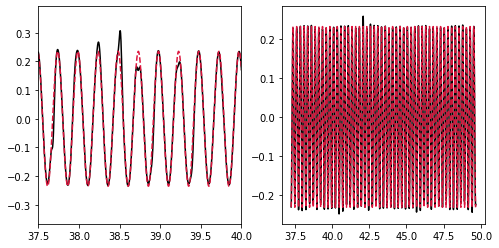

In [1017]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(time_calib, d_eta1 - autonomous_derivative_pred[0,:], '-', c='black')
ax.plot(time_calib, sincos(time_calib, a1, 0), '--', c='crimson')


ax2.plot(time_calib, d_eta2 - autonomous_derivative_pred[1,:], '-', c='black')
ax2.plot(time_calib, sincos(time_calib, a2, 0), '--', c='crimson')
ax.set_xlim(37.5, 40.)#3.5)
#ax2.set_xlim(0, 2)#3.5)


In [1018]:
residual1 = d_eta1 - autonomous_derivative_pred[0,:]
residual2 = d_eta2 - autonomous_derivative_pred[1,:]
residual = np.vstack((residual1, residual2))
forcing = np.vstack((np.cos(time_calib * frq_), np.cos(time_calib * frq_)))

In [1019]:
res = np.linalg.lstsq(forcing.T, residual.T)[0].T

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58706/3425496905.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(forcing.T, residual.T)[0].T


In [1020]:
res

array([[ 0.11763394,  0.11763394],
       [-0.11563503, -0.11563503]])

In [1021]:
a1,b1

(0.23526788567957901, 0.007946396957802764)

In [992]:
a2, b2

(-0.23127006715514878, -0.0033434403768440794)

## With the calibrated derivatives:

In [1121]:
amp_ssm =  2*0.11763394

def odeint_pade_forced(t, x):
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    forcing = np.array([np.cos(t * frq_), np.sin(t * frq_)])
    return autonomous + np.array([2*0.11763394, -2*0.11563503]) * np.cos(frq_ * t)#
#np.array([sincos(t, a1, b1, f1), sincos(t, a2, b2, f2)]) #np.array([ampl_from_ssmtool, -ampl_from_ssmtool]) * np.cos(frq_ * t)#res@forcing




In [1122]:
ic_chaot1_reduced = reduced_traj1[:,0][::-1]
ic_chaot2_reduced = reduced_traj2[:,0][::-1]


In [1123]:
from scipy.integrate import solve_ivp

In [1124]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1125]:
sol_1_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



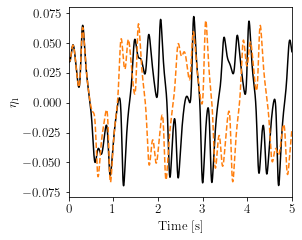

In [1127]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)
#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '--', c='C1', label = 'Reduced trajectory (Padé)')
#ax.plot(sol_1_taylor.t, sol_1_taylor.y[1,:], '-', c='black')
#ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 5)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
plt.savefig('figs/chaot_forced_mid_load_calib.pdf', bbox_inches='tight')

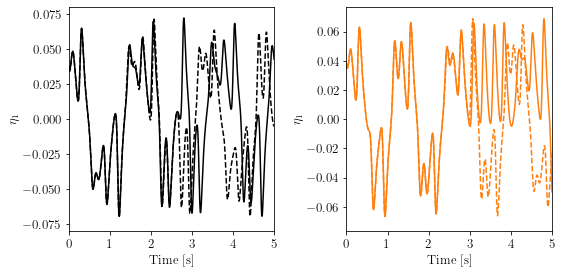

In [1130]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_1_pade.t, reduced_traj2[0,:], '--', c='black', label = 'Reduced trajectory (Padé)')


ax2.plot(sol_1_pade.t, sol_2_pade.y[1,:], '-', c='C1', label = 'True trajectory')
ax2.plot(sol_1_pade.t, sol_1_pade.y[1,:], '--', c='C1', label = 'Reduced trajectory (Padé)')
#ax.plot(sol_1_taylor.t, sol_1_taylor.y[1,:], '-', c='black')
#ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 5)
ax2.set_xlim(0, 5)

#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')


ax2.set_xlabel('Time [s]')
ax2.set_ylabel('$\eta_1$')
plt.tight_layout()
plt.savefig('figs/chaot_forced_mid_load_calib_perturbed.pdf', bbox_inches='tight')

(0.0, 5.0)

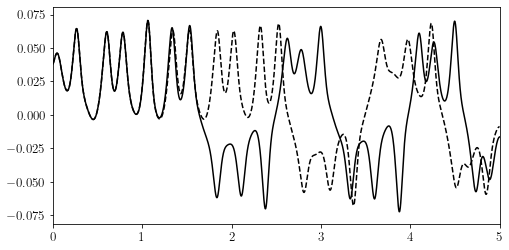

In [1619]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(111)
ax.plot(sol_2_pade.t, sol_2_pade.y[0,:], '-', c='black')
ax.plot(sol_2_pade.t, sol_1_pade.y[0,:], '--', c='black')


ax.set_xlim(0, 5)

(0.0, 5.0)

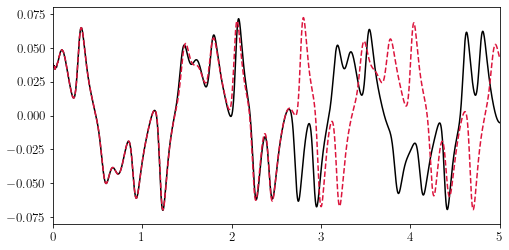

In [1620]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(111)
ax.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
ax.plot(sol_2_pade.t, reduced_traj1[0,:], '--', c='crimson')


ax.set_xlim(0, 5)

In [1064]:
frequencies = np.fft.fftfreq(len(reduced_traj1[1,:]), d=dt)
ff_true = np.fft.fft(reduced_traj1[1,:])
ff_reduced = np.fft.fft(sol_1_pade.y[0,:])
positive_frequencies = frequencies[frequencies >= 0]
positive_power_spectrum_true = ff_true[frequencies >= 0]
positive_power_spectrum_reduced = ff_reduced[frequencies >= 0]

(0.0, 30.0)

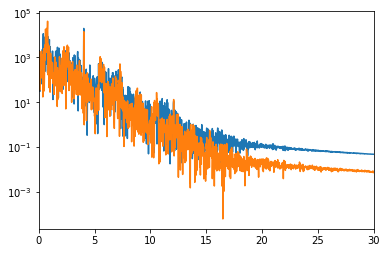

In [1065]:
plt.semilogy(positive_frequencies, np.abs(positive_power_spectrum_true)**2, '-')
plt.semilogy(positive_frequencies, np.abs(positive_power_spectrum_reduced)**2, '-')
plt.xlim(0, 30)

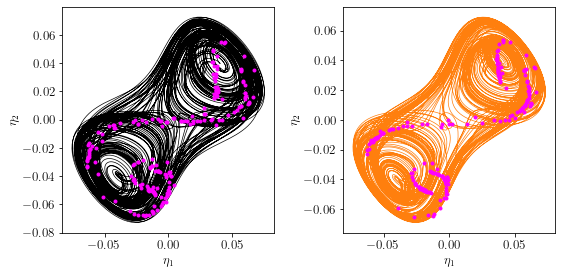

In [1133]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(reduced_traj2[1,:], reduced_traj2[0,:], '-',linewidth =0.7, c='black')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c=colors[5])

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax2.plot(sol_1_pade.y[0,:], sol_1_pade.y[1,:], '-',linewidth =0.7, c='C1')
ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c=colors[5])

ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/chaotic_forced_with_poincare_mid_load_calib.pdf',bbox_inches='tight')

In [1240]:
timescale = 2*np.pi/frq_
numberPeriods = 100
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1243]:
teval = np.linspace(0, 20, 2000)
sol_1_pade_long = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced+1e-3, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
#sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



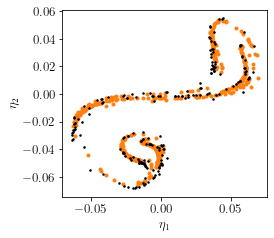

In [1136]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)

#ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black')

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 6, label = 'Reduced trajectory (Padé)')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
#ax.legend(loc = 'lower right')
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/chaotic_forced_only_poincare_mid_load_calib.pdf',bbox_inches='tight')

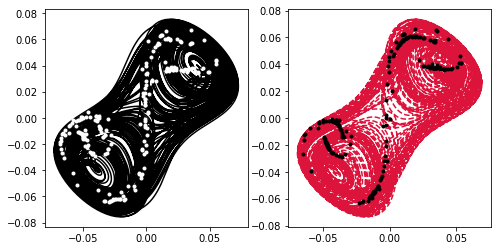

In [1067]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)
ax.plot(reduced_traj2[0,:], reduced_traj2[1,:], '-', c='black')

ax.plot(reduced_traj2[0,::100], reduced_traj2[1,::100], '.', c='white')
#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')

ax2.plot(sol_1_pade.y[1,:], sol_1_pade.y[0,:], '--', c='crimson')

#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax2.plot(sol_1_pade.y[1,::100], sol_1_pade.y[0,::100], '.', c='black')


Bottom line: 

- Projecting the forcing with the eigenvectors gives a slightly different chaos 
- Calibrating the forcing to the end of one trajecotry and enforcing purely cos(\omega t) time dependence gives a better result
- The correspondence is still not 100% but not bad

In [1070]:
pade_traj = [np.real(pp.evaluate(sol_1_pade.y.T))
      for pp in parametrization_pade_54_FULL]

In [1098]:
dat['sol_ep1'].min()

-1.1708307802986562

In [1076]:
np.array(pade_traj)

0.07556963885851326

In [1079]:
dict_to_save = {}
dict_to_save['pade_chaotic_traj'] = np.array(pade_traj)

In [706]:
from scipy.io import savemat


In [1080]:
savemat('bucked_chaotic_pade_calibrated_amplitude.mat', dict_to_save)

## December 3 

bifurcation diagram in amplitude

In [1137]:
2*0.11763394

0.23526788

In [1104]:

amp_low = 2.2*0.0774

In [1139]:
#frequencies = np.linspace(23.2, 24, 20)
#frequencies = np.linspace(20, 30, 40)
amplitudes = np.linspace(0., 0.3, 100)

In [1140]:
resp = []
for a in tqdm(amplitudes):
    timescale = 2*np.pi/frq_
    numberPeriods = 100
    numberPointsPerPeriod = 100
    endTime = numberPeriods*timescale;
    nSamp = numberPeriods*numberPointsPerPeriod+1
    dt = timescale#endTime/(nSamp-1);
    timespan = np.arange(0, endTime, dt)


    
    
    def odeint_pade_forced(t, x):
        autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                       red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
        return autonomous + np.array([a, -a]) * np.cos(frq_ * t)

    sol_chaotic_pade_1 = solve_ivp(odeint_pade_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-6)
    resp.append(sol_chaotic_pade_1.y)


100%|█████████████████████████████████████████| 100/100 [05:40<00:00,  3.40s/it]


In [573]:
frequencies

array([25.25      , 25.25641026, 25.26282051, 25.26923077, 25.27564103,
       25.28205128, 25.28846154, 25.29487179, 25.30128205, 25.30769231,
       25.31410256, 25.32051282, 25.32692308, 25.33333333, 25.33974359,
       25.34615385, 25.3525641 , 25.35897436, 25.36538462, 25.37179487,
       25.37820513, 25.38461538, 25.39102564, 25.3974359 , 25.40384615,
       25.41025641, 25.41666667, 25.42307692, 25.42948718, 25.43589744,
       25.44230769, 25.44871795, 25.45512821, 25.46153846, 25.46794872,
       25.47435897, 25.48076923, 25.48717949, 25.49358974, 25.5       ])

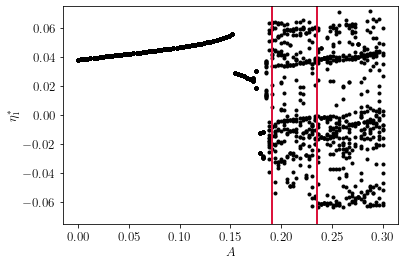

In [1154]:
for a,r in zip(amplitudes,resp):
    plt.plot(a*np.ones(20), r[ 0, -20:], '.', c='black')
plt.plot([amp_ssm, amp_ssm], [-0.7, 0.7], '-', linewidth = 2, c='Crimson')
plt.plot([ampl_from_ssmtool*1.02, ampl_from_ssmtool*1.02], [-0.7, 0.7], '-', linewidth = 2, c='Crimson')

plt.ylim(-0.075, 0.075)
plt.xlabel('$A$')
plt.ylabel('$\eta_1^*$')
plt.savefig('figs/pade_reduced_model_bif_diagram.pdf', bbox_inches='tight')
#plt.xlim(25.3, 25.35)

In [1144]:
amp_ssm

0.23526788

## Try the same thing with Taylor

In [1904]:
def odeint_taylor_forced(t, x):
    autonomous = np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([1.1*amp_low, -1.1*amp_low]) * np.cos(frq_ * t)
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.arange(0, endTime, dt)

In [1905]:
1.1*amp_low

0.18730800000000003

In [1210]:
sol_chaotic_taylor_1 = solve_ivp(odeint_taylor_forced, [0,endTime], ic1, t_eval = timespan, method = 'DOP853', rtol = 1e-12)
sol_chaotic_taylor_2 = solve_ivp(odeint_taylor_forced, [0,endTime], ic2, t_eval = timespan, method = 'DOP853', rtol = 1e-12)

In [1218]:
midpoint_pade_chaot_1 = parametrization_pade[0].evaluate(sol_1_pade.y.T)
midpoint_taylor_chaot_1 = parametrization_18[0].evaluate(sol_chaotic_taylor_1.y.T)


In [ ]:
midpoint.shape

(18,)

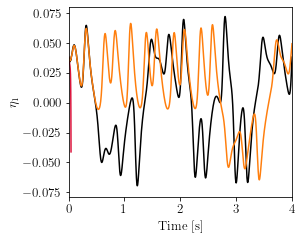

In [1638]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)
#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_chaotic_taylor_1.t, sol_chaotic_taylor_1.y[1,:], '-', c='crimson', label = 'Reduced trajectory (Taylor)')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '-', c='C1')
#ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 4)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
plt.savefig('figs/chatoic_comparison_taylor_pade_projected_forcing.pdf', bbox_inches='tight')

In [1697]:
taylor_traj = [np.real(pp.evaluate(sol_chaotic_taylor_1.y.T))
      for pp in parametrization_18_FULL]

In [1699]:
np.array(taylor_traj).shape

(72, 18)

In [1098]:
dat['sol_ep1'].min()

-1.1708307802986562

In [1076]:
np.array(pade_traj)

0.07556963885851326

In [1700]:
dict_to_save = {}
dict_to_save['pade_chaotic_traj'] = np.array(pade_traj)
dict_to_save['taylor_chaotic_traj'] = np.array(taylor_traj)
dict_to_save['sol_chaotic_taylor_1'] = sol_chaotic_taylor_1.y


In [1701]:
from scipy.io import savemat


In [1702]:
savemat('bucked_chaotic_pade_calibrated_amplitude.mat', dict_to_save)

### December 4: 

extract nonautonomous corrections

In [1516]:

mat_na = loadmat('vonkarman_buckled_mid_load_order2_nonaut.mat')


In [1517]:
mat_na['R1'][0][0][1]['ind'][0][0]#.toarray()

<1x2 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

In [1518]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [1519]:
def reduced_to_full(p, W0):
    N = np.shape(W0[0]['coeffs'])[0]
    z = np.zeros((N,1))*p[0]
    for i in range(len(W0)):
        if len(W0[i]['coeffs'])>0:
            if W0[i]['coeffs'].shape[1]>0:
                z += expand_multiindex(W0[i], p)
    return z

In [1520]:
def extract_gen_new_na(matt,harmonic_index, label):
    mat_array = []
    matt = matt[label][harmonic_index][0][1]
    order = len(matt)
    for i in range(order):
        dictt = {}
        if matt['coeffs'][i].shape[0]>0:
            if isinstance(matt['coeffs'][i][0], sp.sparse.spmatrix):
                dictt['coeffs'] = matt['coeffs'][i][0].toarray()
            else:
                dictt['coeffs'] = matt['coeffs'][i]
            if isinstance(matt['ind'][i][0], sp.sparse.spmatrix):
                print(i, 'a')
                dictt['ind'] = np.array(matt['ind'][i][0].toarray(), dtype=int)
            else:
                dictt['ind'] = np.array(matt['ind'][i][0], dtype= int)
#            dictt['ind'] = matt['ind'][i][0].toarray()
        else:
            dictt['coeffs'] = []
            dictt['ind'] = []
        mat_array.append(dictt)
    return mat_array


In [1521]:
R11 = extract_gen_new_na(mat_na, 0,  'R1') # get reduced dyn


0 a


In [1522]:
R12 = extract_gen_new_na(mat_na, 1,  'R1') # get reduced dyn


0 a


In [1401]:
R11[1]['coeffs'] = 0*R11[1]['coeffs']
R12[1]['coeffs'] = 0*R12[1]['coeffs']

In [1523]:
k1_expression = reduced_to_full(var, R11)
k2_expression = reduced_to_full(var, R12)

In [1524]:
forcing_vector_11 = sy.lambdify([p1, p2], k1_expression[0][0], 'numpy')
forcing_vector_12 = sy.lambdify([p1, p2], k1_expression[1][0], 'numpy')
forcing_vector_21 = sy.lambdify([p1, p2], k2_expression[0][0], 'numpy')
forcing_vector_22 = sy.lambdify([p1, p2], k2_expression[1][0], 'numpy')

In [1594]:
forcing_vector_11(0,0)*2*amp_full

(0.2267033242968807+0j)

In [1537]:
red_dynamics_nonaut_k1 = return_parametrization_up_to_order_Taylor(k1_expression,max_order = 18)


In [1538]:
red_dynamics_nonaut_k2 = return_parametrization_up_to_order_Taylor(k2_expression,max_order = 18)


In [1565]:
nonaout_pade_k1 = generate_parametrization(red_dynamics_nonaut_k1,
                                                order_num = 5,
                                                order_denom = 5,
                                                use_robust = True)

In [1566]:
nonaout_pade_k2 = generate_parametrization(red_dynamics_nonaut_k2,
                                                order_num = 5,
                                                order_denom = 5,
                                                use_robust = True)

In [1906]:
amp_ssm =  2*0.11763394
amp_full = 21.1154
def odeint_pade_forced(t, x):
    phase = frq_ * t
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    # forcing = np.array([nonaout_pade_k1[0].evaluate(0*x.reshape(1,-1)) * np.exp(1j*phase) 
    #                     + nonaout_pade_k2[0].evaluate(0*x.reshape(1,-1)) * np.exp(-1j*phase),
    #                nonaout_pade_k1[1].evaluate(0*x.reshape(1,-1))*np.exp(1j*phase) + 
    #                    nonaout_pade_k2[1].evaluate(0*x.reshape(1,-1)) * np.exp(-1j*phase)]).ravel()
    # #
    return autonomous + np.array([0.2267033242968807, -0.2267033242968807])*np.cos(frq_ * t)#amp_full*np.real(forcing)#*np.cos(frq_*t)#np.array([2*0.11763394, -2*0.11563503]) * np.cos(frq_ * t)#
#np.array([sincos(t, a1, b1, f1), sincos(t, a2, b2, f2)]) #np.array([ampl_from_ssmtool, -ampl_from_ssmtool]) * np.cos(frq_ * t)#res@forcing




In [1907]:
2*amp_full*forcing_vector_11(0,0)

(0.2267033242968807+0j)

In [1908]:
ic_chaot1_reduced = reduced_traj1[:,0][::-1]
ic_chaot2_reduced = reduced_traj2[:,0][::-1]


In [1909]:
from scipy.integrate import solve_ivp

In [1910]:
frq_

25.30769231

In [1911]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1912]:
sol_1_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



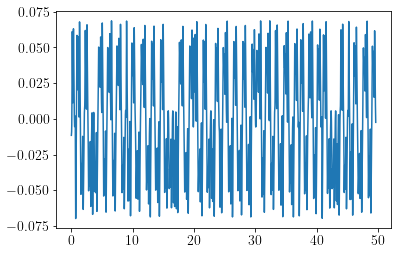

In [1913]:
plt.plot(sol_1_pade.t, sol_1_pade.y[1,:])

In [1981]:
signal_true = reduced_traj1[1,:] - np.mean(reduced_traj1[1,:])
signal_pade = sol_1_pade.y[0,:] - np.mean(sol_1_pade.y[0,:])

frequencies = np.fft.fftfreq(len(signal_true), d=dt)
ff_true = np.fft.fft(signal_true)
ff_reduced = np.fft.fft(signal_pade)
positive_frequencies = frequencies[frequencies >= 0]
positive_power_spectrum_true = ff_true[frequencies >= 0]
positive_power_spectrum_reduced = ff_reduced[frequencies >= 0]

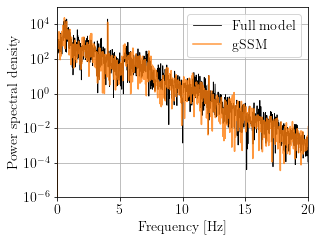

In [1996]:
ff = plt.figure(figsize = (4.5,3.5))
ax = ff.add_subplot(111)

ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_true)**2, '-', c='black',label = 'Full model', linewidth =0.8)
ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_reduced)**2, '-', c='C1',label = 'gSSM', alpha = 0.8)
ax.set_xlim(0, 20)
ax.set_ylim(1e-6, 1e5)
ax.grid()
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power spectral density')

plt.savefig('figs/psd_plot.pdf', bbox_inches='tight')




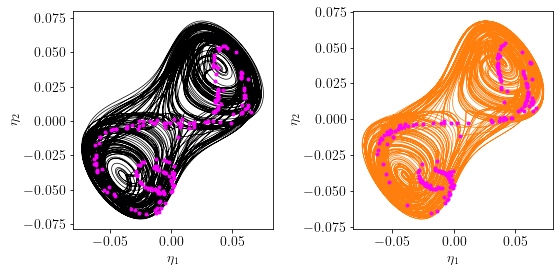

In [1985]:
ff = plt.figure(figsize = (8,4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(reduced_traj2[1,:], reduced_traj2[0,:], '-',linewidth =0.7, c='black')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c=colors[5])

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax2.plot(sol_1_pade.y[0,:], sol_1_pade.y[1,:], '-',linewidth =0.7, c='C1')
ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c=colors[5])

ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()


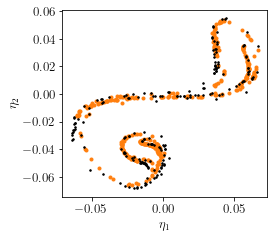

In [1607]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)

#ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black')

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 6, label = 'Reduced trajectory (Padé)')
ax.plot(sol_2_pade.y[0,::100], sol_2_pade.y[1,::100], '.', c='C1', markersize = 6, label = 'Reduced trajectory (Padé)')

ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
#ax.legend(loc = 'lower right')
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
plt.tight_layout()
#plt.savefig('figs/chaotic_forced_only_poincare_mid_load_calib.pdf',bbox_inches='tight')

NameError: name 'sol_1_taylor' is not defined

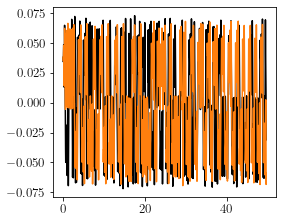

In [1635]:
ff = plt.figure(figsize = (4,3.5))
ax = ff.add_subplot(111)
#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '-', c='C1', label = 'Reduced trajectory (Padé)')
ax.plot(sol_1_taylor.t, sol_1_taylor.y[1,:], '-', c='black')
#ax.legend()

# ax2.plot(sol_2_pade.t, reduced_traj2[0,:], '-', c='black')
# ax2.plot(sol_2_pade.t, sol_2_pade.y[1,:], '--', c='Orange')
#ax2.plot(sol_2_taylor.t, sol_2_taylor.y[1,:], '-', c='black')
ax.set_xlim(0, 5)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
plt.savefig('figs/chaot_forced_mid_load_calib.pdf', bbox_inches='tight')

In [1609]:
sol_1_pade.y

array([[ 0.03827587,  0.03886479,  0.03947171, ..., -0.01058444,
        -0.00907363, -0.00766196],
       [ 0.03796997,  0.03742222,  0.03692122, ..., -0.06245681,
        -0.06094443, -0.05933662]])

In [1610]:
frq_

25.30769231

Crude Lyap. calculation: 

In [1915]:
diff_sim = np.linalg.norm(sol_1_pade.y - sol_2_pade.y, axis = 0)
diff_true = np.linalg.norm(reduced_traj1 - reduced_traj2, axis = 0)


In [1916]:
from scipy.optimize import curve_fit

In [1917]:
def lin_(x, a, b):
    return a*x + b

In [1941]:
to_fit_t = sol_1_pade.t[0:2000]

In [1942]:
popt_pad, pcov_pad = curve_fit(lin_, to_fit_t, np.log(diff_sim[0:2000]))
popt_true, pcov_true = curve_fit(lin_, to_fit_t, np.log(diff_true[0:2000]))


In [1943]:
popt_pad

array([  2.998364  , -17.86658451])

In [1944]:
popt_true

array([  3.09044395, -16.45312428])

In [1954]:
np.sqrt(np.diag(pcov_pad))

array([0.01997339, 0.05723814])

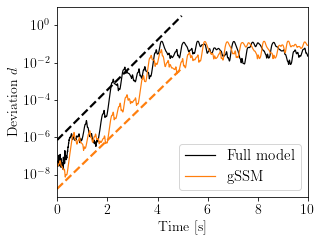

In [1980]:
ff = plt.figure(figsize = (4.5,3.5))
ax = ff.add_subplot(111)

ax.semilogy(sol_1_pade.t, diff_true, '-', c='black', linewidth = 1.2, label = 'Full model')
ax.semilogy(sol_1_pade.t, diff_sim, '-', c = 'C1', linewidth = 1.2, label = 'gSSM')
ax.semilogy(to_fit_t, 0.1*np.exp(popt_pad[1]) * np.exp(popt_pad[0] * to_fit_t), '--', c='C1', linewidth = 2.2)
ax.semilogy(to_fit_t, 10*np.exp(popt_true[1]) * np.exp(popt_true[0] * to_fit_t), '--', c='black', linewidth = 2.2)
#plt.semilogy(sol_1_pade.t, diff_true)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Deviation $d$')
ax.legend(fontsize = 15)
ax.set_xlim(0, 10)
plt.savefig('figs/Lyapunov_exp.pdf', bbox_inches = 'tight')

In [1621]:
timescale = 2*np.pi/frq_
numberPeriods = 600
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [1622]:
teval = np.linspace(0, 20, 2000)
sol_1_pade_long = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
#sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



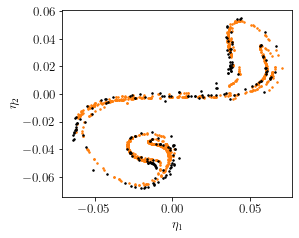

In [1640]:
ff = plt.figure(figsize = (4.5,3.5))
ax = ff.add_subplot(111)

#ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black')

#ax.plot(sol_1_pade.t, sol_1_pade.y[0,:], '--', c='crimson')


#ax2.plot(sol_2_pade.t, reduced_traj2[1,:], '-', c='black')
ax.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax.plot(sol_2_pade.y[0,::100], sol_2_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
#ax.legend(loc = 'lower right')
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
plt.tight_layout()
plt.savefig('figs/chaotic_forced_only_poincare_mid_load_fixed_proj.pdf',bbox_inches='tight')

### December 9 

Computing the average Lyapunov exponent: 

In [1761]:
init_points = sol_1_pade.y[:, :15000][:, ::200]
indices = np.linspace(0, sol_1_pade.y[:, :15000].shape[1]-1, sol_1_pade.y[:, :15000].shape[1], dtype = int)[::200]
length_ = 5000
init_times = sol_1_pade.t[indices]

In [1762]:
np.random.seed(3)
perturbed_evolution = []
for i,p in tqdm(enumerate(init_points.T)):
    perturb = (np.random.rand(2) -0.5) * 2 * 1e-7
    ic = p + perturb
    tmin = init_times[i]
    teval = sol_1_pade.t[indices[i]:indices[i] + length_]
    tmax = teval[-1]
    sol_pade = solve_ivp(odeint_pade_forced, [tmin, tmax], ic, t_eval = teval, method = 'RK45', rtol = 1e-8, atol = 1e-10)
    perturbed_evolution.append(sol_pade)

75it [10:19,  8.26s/it]


In [1764]:
differences = []
for i,p in enumerate(perturbed_evolution):
    reference = sol_1_pade.y[:, indices[i]:indices[i] + length_]
    diff_ = np.linalg.norm(reference - p.y, axis = 0)
    differences.append(diff_)


In [1765]:
time_axis = sol_1_pade.t[0:length_]

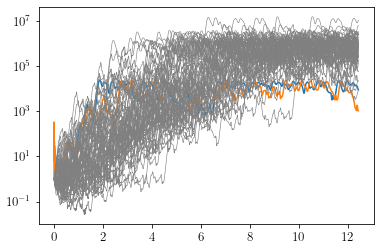

In [1766]:

plt.semilogy(time_axis, diff_sim[0:length_]/diff_sim[0])
plt.semilogy(time_axis, diff_true[0:length_]/diff_true[0])
for d in differences:
    plt.semilogy(time_axis, d/d[0], '-', c='grey', linewidth = 0.6)
#plt.semilogy(sol_1_pade.t, diff_true)

#plt.xlim(0, 2.5)

In [1945]:
to_fit_indices = np.logical_and(time_axis<5, time_axis > 0)
to_fit_time = time_axis[to_fit_indices]

In [1946]:
exponents = []
errors = []
for d in differences:
    popt, pcov = curve_fit(lin_, to_fit_time, np.log(d[to_fit_indices]/d[0]))
    err = np.sqrt(np.diag(pcov))
    exponents.append(popt)
    errors.append(err)

<function matplotlib.pyplot.ylim(*args, **kwargs)>

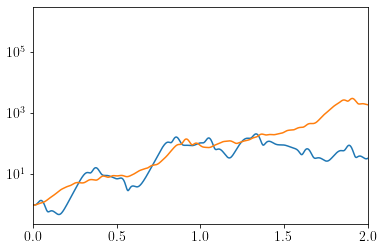

In [1947]:
plt.semilogy(time_axis, differences[3]/differences[3][0])
plt.semilogy(time_axis, avg_diff/avg_diff[0])
plt.xlim(0, 2)
plt.ylim

In [1948]:
np.sqrt(np.std(exponents))

1.2953129934460574

In [1949]:
np.mean(exponents)

0.9005786647549218

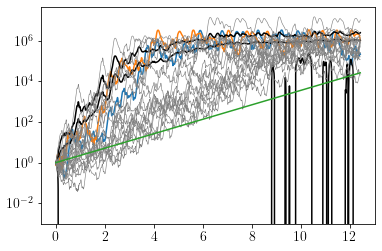

In [1924]:

plt.semilogy(time_axis, diff_sim[0:length_]/diff_sim[0])
plt.semilogy(time_axis, diff_true[0:length_]/diff_true[0])
avg_diff = np.average(np.array([d/d[0] for d in differences]), axis = 0)
std_diff = np.std(np.array([d/d[0] for d in differences]), axis = 0)
plt.plot(time_axis, avg_diff,  '-', c='black')
plt.plot(time_axis, avg_diff+std_diff,  '-', c='black')
plt.plot(time_axis, avg_diff-std_diff, '-', c='black')
for d in differences[50:70]:
    plt.semilogy(time_axis, d/d[0], '-', c='grey', linewidth = 0.6)
#plt.semilogy(sol_1_pade.t, diff_true)
plt.plot(time_axis, np.exp(.82 * time_axis))
#plt.xlim(0, 2.5)

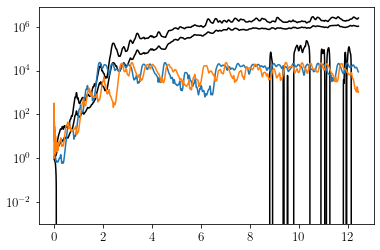

In [1808]:
plt.plot(time_axis, avg_diff,  '-', c='black')
plt.plot(time_axis, avg_diff+std_diff,  '-', c='black')
plt.plot(time_axis, avg_diff-std_diff, '-', c='black')
plt.semilogy(time_axis, diff_sim[0:length_]/diff_sim[0])
plt.semilogy(time_axis, diff_true[0:length_]/diff_true[0])

In [1798]:
np.array(differences).shape

(75, 5000)

In [1759]:
diff_true[0]

6.019662158749059e-06

In [1760]:
diff_sim[0]

6.019662158749059e-06

In [1838]:
to_fit_indices = np.logical_and(time_axis<2, time_axis > 0)


In [1846]:
popt_avg, pcov_avg = curve_fit(lin_, time_axis[to_fit_indices], np.log(avg_diff[:, :15000][:length_][to_fit_indices]/avg_diff[0]))
#popt_true, pcov_true = curve_fit(lin_, to_fit_t, np.log(diff_true[100:600]))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [1853]:
popt_std, pcov_std = curve_fit(lin_, time_axis[to_fit_indices], np.log((avg_diff+std_diff)[to_fit_indices]/(avg_diff[0]+std_diff[0])))


In [1855]:
popt_std-popt_avg

array([0.32218668, 1.0435937 ])

In [1830]:
popt_avg

array([3.6674523 , 0.45022965])

In [1847]:
popt_tr, pcov_tr= curve_fit(lin_, time_axis[to_fit_indices], np.log(diff_true[:15000][:length_][to_fit_indices]/diff_true[0]))



In [1849]:
popt_avg

array([3.6674523 , 0.45022965])

In [1852]:
np.sqrt(np.diag(pcov_avg))

array([0.02325312, 0.02685643])

In [1953]:
popt_tr

array([ 1.90152094, -0.10036361])

In [1851]:
np.sqrt(np.diag(pcov_tr))

array([0.04849192, 0.05600624])

In [1950]:
avg_diff_log = np.average(np.array([np.log(d/d[0]) for d in differences]), axis = 0)
#std_diff = np.std(np.array([d/d[0] for d in differences]), axis = 0)

In [1951]:
popt_tr, pcov_tr= curve_fit(lin_, time_axis[to_fit_indices], avg_diff_log[to_fit_indices])


In [1952]:
np.sqrt(np.diag(pcov_tr))

array([0.0010711 , 0.00309173])

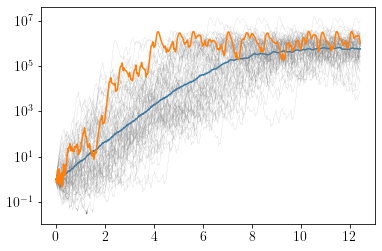

In [1927]:
#plt.plot(time_axis, avg_diff,  '-', c='black')
#plt.plot(time_axis, avg_diff+std_diff,  '-', c='black')
#plt.plot(time_axis, avg_diff-std_diff, '-', c='black')
plt.plot(time_axis, np.exp(avg_diff_log))
for d in differences[1:70]:
    plt.semilogy(time_axis, d/d[0], '-', c='grey', linewidth = 0.1)
#plt.semilogy(time_axis, diff_sim[0:length_]/diff_sim[0])
plt.semilogy(time_axis, diff_true[0:length_]/diff_true[0])

## December 11

prepare initial condition for full sym

In [1862]:
np.random.seed(3)
Ic_avg = np.average(init_points, axis = 1)
perturb = (np.random.rand(2) -0.5) * 2 * 1e-7
Ic_pert = Ic_avg + perturb


In [1873]:
pade_traj_ic_full_1 = [np.real(pp.evaluate(Ic_avg.reshape(1,-1)))
      for pp in parametrization_pade_54_FULL]
pade_traj_ic_full_2 = [np.real(pp.evaluate(Ic_pert.reshape(1,-1)))
      for pp in parametrization_pade_54_FULL]

In [1874]:
dict_to_save = {}
dict_to_save['pade_traj_ic_full_1'] = np.array(pade_traj_ic_full_1)
dict_to_save['pade_traj_ic_full_2'] = np.array(pade_traj_ic_full_2)

In [1875]:
savemat('bucked_chaotic_pade_IC_avg.mat', dict_to_save)

## Draw Joint figure: 

In [1889]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

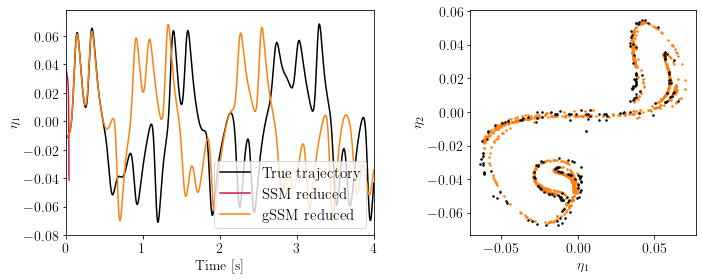

In [1914]:
aspect_ratio = 443/173
width = 10.5521
ff = plt.figure(figsize = (width,width/aspect_ratio))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

#ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_chaotic_taylor_1.t, sol_chaotic_taylor_1.y[1,:], '-', c='crimson', label = 'SSM reduced')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '-', c='C1', label = 'gSSM reduced')
ax.legend(loc = 'lower right', fontsize = 15)

ax2.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(sol_2_pade.y[0,::100], sol_2_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
#ax.legend(loc = 'lower right')
ax2.set_xlabel('$\eta_1$')
ax2.set_ylabel('$\eta_2$')
#plt.savefig('figs/chaotic_forced_only_poincare_mid_load_fixed_proj.pdf',bbox_inches='tight')

ax.set_xlim(0, 4)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
ax2.set_aspect(1.1)
plt.tight_layout()

#plt.savefig('figs/chatoic_comparison_taylor_pade_projected_forcing_poincare.pdf', bbox_inches='tight')

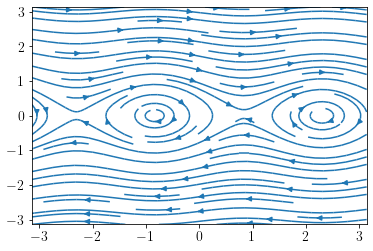

In [2009]:
xx = np.linspace(-np.pi, np.pi, 20)
yy= np.linspace(-np.pi, np.pi, 20)
X, Y = np.meshgrid(xx, yy)
U = Y
b = -0.45
V = -np.cos(X)**2 - b
plt.streamplot(X, Y, U, V)